<a href="https://colab.research.google.com/github/arv-1234/Integrated-Financial-Forecasting-NYSE-/blob/main/Stock_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Predicting Stock Market Direction (2016)

### **Objective**
* **Goal:** Predict if a stock's price will close **HIGHER (1)** or **LOWER (0)** on the next day.
* **Model:** Random Forest Classifier (Non-linear).
* **Data Scope:**
    * **Focus Year:** 2016 (Jan – Dec).
    * **Methodology:** We utilize the full 2016 dataset for both training and testing. The data will be split (e.g., 80% Train / 20% Test) to validate how well the model learns patterns within this specific market year.

## 1. Import Libraries

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 2. Import Files

In [105]:
# Find CSV files in directory
files = glob.glob("/content/*.csv")

# Dictionairy to store the data
dataFrame = {}

# Add data to dataFrame
for file in files:
  fileName = os.path.basename(file)
  dataKey = os.path.splitext(fileName)[0]
  dataFrame[dataKey] = pd.read_csv(file)


# 3. Conduct checks for each file
  * prices-split-adjusted
  * securities
  * fundamentals
  

## a) prices-split-adjusted

In [106]:
# Create data frame for price split adjusted file
priceSplitDf = dataFrame['prices-split-adjusted']
priceSplitDf['date'] = pd.to_datetime(priceSplitDf['date'])

# Add Next day direction to price file
priceSplitDf = priceSplitDf.sort_values(by=['symbol', 'date'])
priceSplitDf['Next_Close'] = priceSplitDf.groupby('symbol')['close'].shift(-1)
priceSplitDf['Target_Direction'] = (priceSplitDf['Next_Close'] > priceSplitDf['close']).astype(int)

# Filter data for 2016 only
priceSplit2016_df = priceSplitDf[priceSplitDf['date'].dt.year == 2016].copy()


# Create 5 different data frames for high, low, close, volume, open
highDf = priceSplit2016_df[['date', 'symbol', 'high']].copy()
lowDf = priceSplit2016_df[['date', 'symbol', 'low']].copy()
closeDf = priceSplit2016_df[['date', 'symbol', 'close', 'Target_Direction']].copy()
volumeDf = priceSplit2016_df[['date', 'symbol', 'volume']].copy()
openDf = priceSplit2016_df[['date', 'symbol', 'open']].copy()

# Verify data has been loaded correctly
print("\n-------------Data filterd for 2016-------------\n")
print(f"Total Rows for 2016: {priceSplit2016_df.shape}\n")
print(f"Total Rows for High: {highDf.shape}\n")
print(f"Total Rows for Low: {lowDf.shape}\n")
print(f"Total Rows for Close: {closeDf.shape}\n")
print(f"Total Rows for Volume: {volumeDf.shape}\n")
print(f"Total Rows for Open: {openDf.shape}\n")




-------------Data filterd for 2016-------------

Total Rows for 2016: (126125, 9)

Total Rows for High: (126125, 3)

Total Rows for Low: (126125, 3)

Total Rows for Close: (126125, 4)

Total Rows for Volume: (126125, 3)

Total Rows for Open: (126125, 3)



### Check for Missing Vales



In [107]:
print("\n----------Missing Values----------\n")
print(f"close: {closeDf['close'].isnull().sum()}")
print(f"high: {highDf['high'].isnull().sum()}")
print(f"low: {lowDf['low'].isnull().sum()}")
print(f"open: {openDf['open'].isnull().sum()}")
print(f"volume: {volumeDf['volume'].isnull().sum()}")


----------Missing Values----------

close: 0
high: 0
low: 0
open: 0
volume: 0


### Check for Negative Values

In [108]:
closeNegative = closeDf[closeDf['close'] < 0]
highNegative = highDf[highDf['high'] < 0]
lowNegative = lowDf[lowDf['low'] < 0]
openNegative = openDf[openDf['open'] < 0]
volumeNegative = volumeDf[volumeDf['volume'] < 0]

print("\n----------Negative Values----------\n")
print(f"close: {len(closeNegative)}")
print(f"high: {len(highNegative)}")
print(f"low: {len(lowNegative)}")
print(f"open: {len(openNegative)}")
print(f"volume: {len(volumeNegative)}")


----------Negative Values----------

close: 0
high: 0
low: 0
open: 0
volume: 0


### Check if low < high

In [109]:
invalidRows = lowDf[lowDf['low'] > highDf['high']]
print(f"Invalid Rows: {len(invalidRows)}")

Invalid Rows: 0


### Descriptive Statistics

#### Close Statistics

In [110]:
closeDf['close'].describe().round(2)

,close
count,126125.00
mean,84.94
std,103.31
min,1.59
25%,39.42
50%,63.66
75%,95.72
max,1578.13


#### Open Statistics

In [111]:
openDf['open'].describe().round(2)

,open
count,126125.00
mean,84.91
std,103.30
min,1.66
25%,39.39
50%,63.65
75%,95.69
max,1584.44


#### High Statistics

In [112]:
highDf['high'].describe().round(2)

,high
count,126125.00
mean,85.75
std,104.21
min,1.81
25%,39.89
50%,64.28
75%,96.57
max,1600.93


#### Low Statistics

In [113]:
lowDf['low'].describe().round(2)

,low
count,126125.00
mean,84.06
std,102.34
min,1.50
25%,38.95
50%,62.99
75%,94.74
max,1549.94


#### Volume Statistics

In [114]:
volumeDf['volume'].describe().apply(lambda x: format(x, 'f')).round(2)

,volume
count,126125.000000
mean,4645940.200595
std,8652551.435066
min,0.000000
25%,1221600.000000
50%,2354800.000000
75%,4789100.000000
max,375088700.000000


#### **Distribution of Daily Returns (Market Behavior)**

**Objective**
Before training the model, we visualize the distribution of daily percentage changes to understand the fundamental statistical properties of the target variable.

**Formula**
$$Return_t = \frac{Price_t - Price_{t-1}}{Price_{t-1}}$$



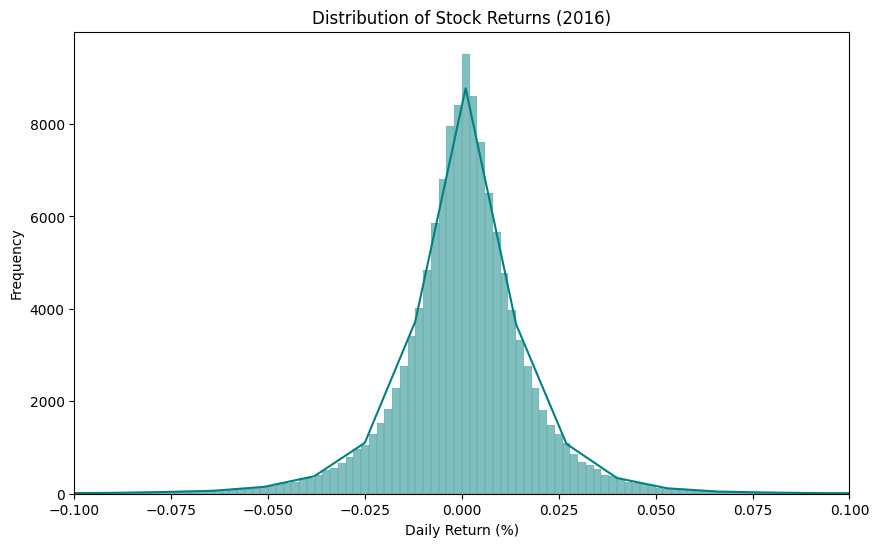

In [115]:


# Sort data based on date
closeDf = closeDf.sort_values(by=['symbol','date'])

# Calculate daily returns
returnDaily = closeDf.groupby('symbol')['close'].pct_change().dropna()

plt.figure(figsize=(10, 6))
sns.histplot(returnDaily, bins=100, kde=True, color='teal', binrange=(-0.10, 0.10))
plt.title('Distribution of Stock Returns (2016)')
plt.xlabel('Daily Return (%)')
plt.xlim(-0.10, 0.10)
plt.ylabel('Frequency')
plt.show()



#### **Kurtosis Analysis (Tail Risk)**

**Objective**
Quantify the "heaviness" of the distribution's tails to measure the frequency of extreme outliers (market crashes or rallies) compared to a standard Normal Distribution (Bell Curve).

*(Note: Pandas calculates "Excess Kurtosis," where a Normal Distribution = 0. A value > 0 indicates "Fat Tails".)*





In [116]:
# Calucalte Excess Kurtosis with Pandas librairy
# High positive value = Fat tails -> More extreme values
valueKurt = returnDaily.kurtosis()

print(f"Kurtosis Value: {valueKurt:.2f}")

# Check for outliers that influence the score
print(f"Max Value: {returnDaily.max():.2f}")
print(f"Min Value: {returnDaily.min():.2f}")

Kurtosis Value: 1649.35
Max Value: 2.10
Min Value: -0.49


#### **Volatility Analysis (Intraday Risk)**

**Objective**
The goal of this analysis is to understand how unstable or “noisy” a stock’s price is within a single trading day. We measure this by examining how much the price fluctuates between the daily high and low relative to the opening price.

**Formula**
$$Volatility = \frac{High - Low}{Open}$$


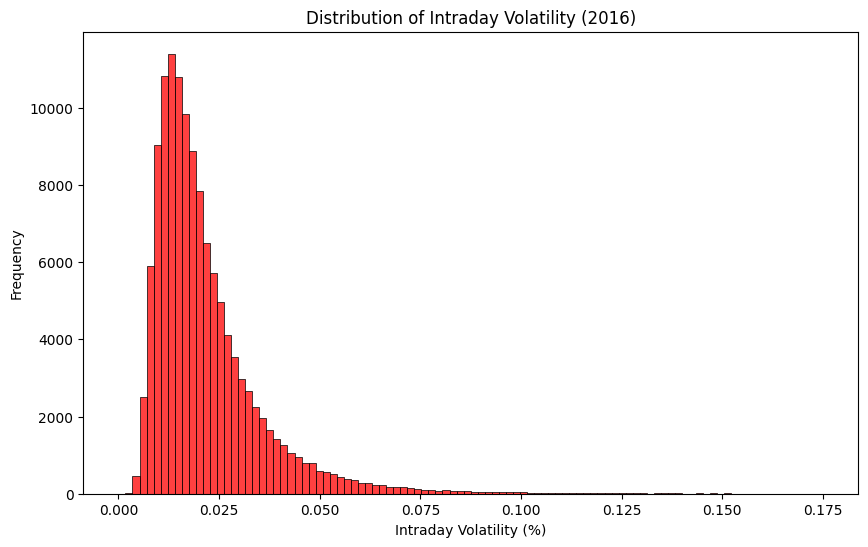

In [117]:
# Create temp data frame for volatility
volatilityDF = priceSplit2016_df.copy()

# Calculate volatility
volatilityDF['IntradayVolatility'] = (volatilityDF['high'] - volatilityDF['low']) / volatilityDF['open']

# Create graph
plt.figure(figsize=(10, 6))
sns.histplot(volatilityDF['IntradayVolatility'], bins=100, color='red', binrange=(0, 0.175))
plt.title("Distribution of Intraday Volatility (2016)")
plt.xlabel("Intraday Volatility (%)")
plt.ylabel("Frequency")
plt.show()


#### **Correlation Analysis (Multicollinearity Check)**

**Objective**
To determine if our raw features (`Open`, `High`, `Low`, `Close`) provide unique information or if they are redundant. In machine learning, strongly correlated features (Multicollinearity) can confuse certain models and add computational cost without adding value.



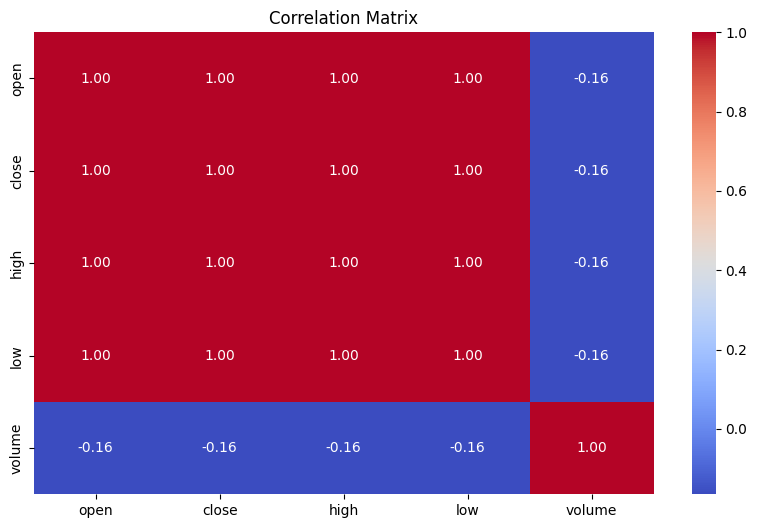

In [118]:
matrixCorr = priceSplit2016_df[['open', 'close', 'high', 'low', 'volume']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(matrixCorr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## b) securities

In [119]:
# Create dataframe for securities file
secDF = dataFrame['securities']


### General Information Check

In [120]:
# Check file structure
secDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Ticker symbol            505 non-null    object
 1   Security                 505 non-null    object
 2   SEC filings              505 non-null    object
 3   GICS Sector              505 non-null    object
 4   GICS Sub Industry        505 non-null    object
 5   Address of Headquarters  505 non-null    object
 6   Date first added         307 non-null    object
 7   CIK                      505 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 31.7+ KB


### Check for Missing Vales


In [121]:
# Check for missing values
print(secDF.isnull().sum())

Ticker symbol                0
Security                     0
SEC filings                  0
GICS Sector                  0
GICS Sub Industry            0
Address of Headquarters      0
Date first added           198
CIK                          0
dtype: int64


### Check for Duplicate Tickers

In [122]:
# Check for Duplicate Tickers
tickerDuplicate = secDF['Ticker symbol'].duplicated().sum()

print(f"Number of Duplicate Tickers: {tickerDuplicate}")

Number of Duplicate Tickers: 0


### Check distribution for GICS sectors


In [123]:
# Check distribution for GICS sectors
numberOfSectors = secDF['GICS Sector'].value_counts()
print(numberOfSectors)

GICS Sector
Consumer Discretionary         85
Industrials                    69
Information Technology         68
Financials                     64
Health Care                    59
Consumer Staples               37
Energy                         36
Real Estate                    29
Utilities                      28
Materials                      25
Telecommunications Services     5
Name: count, dtype: int64


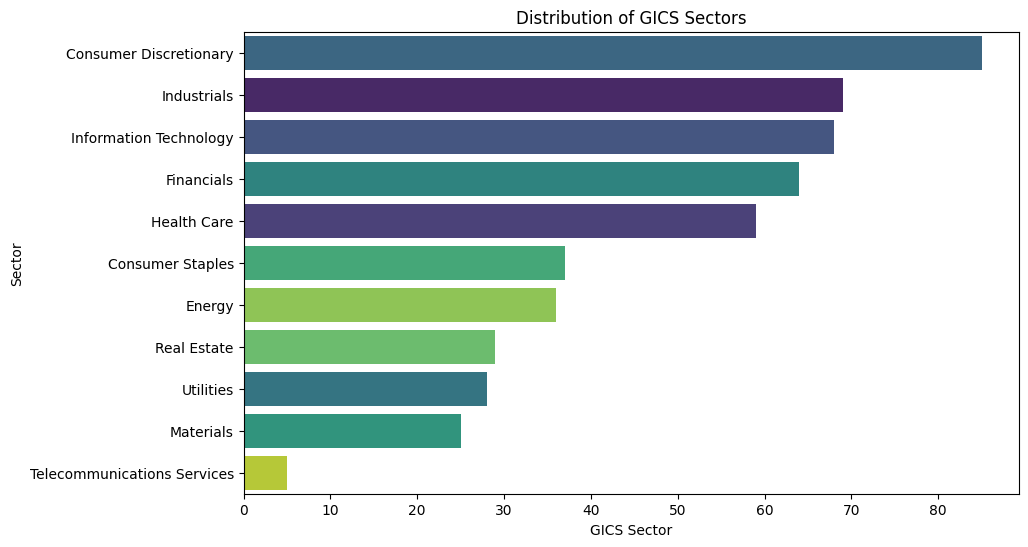

In [124]:
# Visualization for Sector counts
plt.figure(figsize=(10, 6))
sns.countplot(data=secDF, y='GICS Sector', palette='viridis', order=numberOfSectors.index, hue='GICS Sector')
plt.title('Distribution of GICS Sectors')
plt.xlabel('GICS Sector')
plt.ylabel('Sector')
plt.show()

### Ticker check with 2016 price data


In [125]:
# Compare Tickers in price and securities files
symbolPrice = set(priceSplit2016_df['symbol'].unique())
symbolSec = set(secDF['Ticker symbol'].unique())

missingSymbols = symbolPrice - symbolSec

print(f"Number of missing symbols: {len(missingSymbols)}")


Number of missing symbols: 0


## c) fundamentals

In [126]:
# Create dataframe for fundamentals file
fundDF = dataFrame['fundamentals']

# Key columns for fundamentals file
keyCols = ['Ticker Symbol', 'Period Ending', 'After Tax ROE',
           'Current Ratio', 'Quick Ratio', 'Earnings Per Share',
           'Total Assets', 'Total Liabilities', 'Total Equity'
           ]

### Check for missing values


In [127]:
# Check for missing values
print(fundDF[keyCols].isnull().sum())


Ticker Symbol           0
Period Ending           0
After Tax ROE           0
Current Ratio         299
Quick Ratio           299
Earnings Per Share    219
Total Assets            0
Total Liabilities       0
Total Equity            0
dtype: int64


### Statisitcal summary

In [128]:
# Statistical summary for key columns
print(fundDF[keyCols].describe().round(2))

       After Tax ROE  Current Ratio  Quick Ratio  Earnings Per Share  \
count        1781.00        1482.00      1482.00             1562.00   
mean           43.60         186.77       146.95                3.35   
std           233.92         128.07       118.63                4.70   
min             0.00          17.00        10.00              -61.20   
25%            10.00         109.00        77.25                1.59   
50%            16.00         152.00       115.00                2.81   
75%            26.00         226.00       180.00                4.59   
max          5789.00        1197.00      1197.00               50.09   

       Total Assets  Total Liabilities  Total Equity  
count  1.781000e+03       1.781000e+03  1.781000e+03  
mean   5.570921e+10       4.380420e+10  1.188846e+10  
std    2.033590e+11       1.817039e+11  2.584429e+10  
min    2.705000e+06       2.577000e+06 -1.324400e+10  
25%    6.552689e+09       3.843300e+09  2.201492e+09  
50%    1.517000e+10  

### Outlier checks for ratios

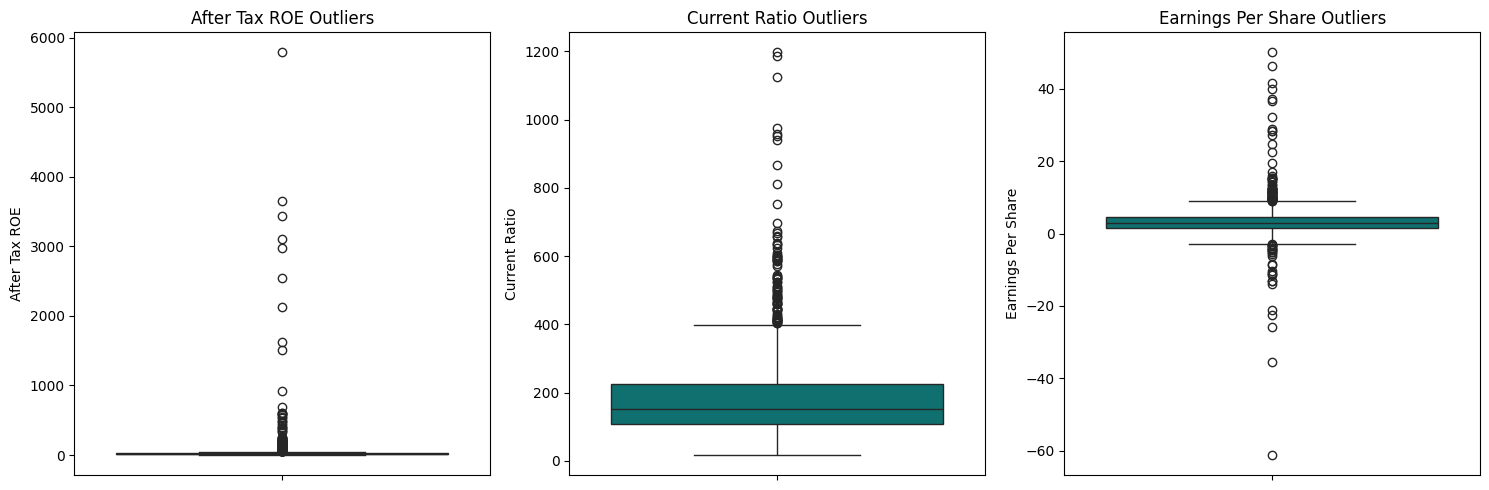

In [129]:
# Outlier visualizations
plt.figure(figsize=(15, 5))

# Plot for After Tax ROE
plt.subplot(1, 3, 1)
sns.boxplot(y=fundDF['After Tax ROE'], color='teal')
plt.title('After Tax ROE Outliers')

# Plot for Current Ratio
plt.subplot(1, 3, 2)
sns.boxplot(y=fundDF['Current Ratio'], color='teal')
plt.title('Current Ratio Outliers')

# Plot for Earnings Per Share
plt.subplot(1, 3, 3)
sns.boxplot(y=fundDF['Earnings Per Share'], color='teal')
plt.title('Earnings Per Share Outliers')


plt.tight_layout()
plt.show()



### Ticker check for fundamentals and price data

In [130]:
# Compare tickers in price and fundamentals file

priceSymbols = set(priceSplit2016_df['symbol'].unique())
fundSymbols = set(fundDF['Ticker Symbol'].unique())

commonSymbols = priceSymbols.intersection(fundSymbols)

missingSymbols = fundSymbols - priceSymbols

print(f"Total stocks for price data: {len(priceSymbols)}")
print(f"Total stocks for fundamentals data: {len(fundSymbols)}")
print(f"Total common stocks: {len(commonSymbols)}")
print(f"Total missing stocks: {len(missingSymbols)}")

Total stocks for price data: 501
Total stocks for fundamentals data: 448
Total common stocks: 447
Total missing stocks: 1
